# Generación de descargas parciales artificiales en árboles eléctricos usando DCGAN

**Nicolás Pinto**

Uno de los principales mecanismos de falla a largo plazo en el aislamiento polimérico sólido de alta tensión son los árboles eléctricos, estos corresponden a túbulos de degradación huecos que crecen bajo un alto estrés eléctrico y la actividad de descargas parciales (DP). Una forma de estudiar este fenómeno es por medio de simulaciones computaciones, de modo que se hace necesario modelar el proceso de descargas parciales. Sin embargo, Dado el volumen de descargas parciales ocurridas durante el proceso de formación junto con la dinámica de estas, hacen que la complejidad computacional del modelo crezca al punto de hacer imposible realizar este modelamiento. Durante este trabajo se presenta un método de generación de descargas parciales de forma artificial, el cual se basa en una "Conditional Convolutional Generative Adversarial Network" (Conditional DCGAN), la cual en base a muestras de descargas parciales ocurridas en un cierto instante del proceso de formación del árbol eléctrico, genera descargas parciales artificiales que posteriormente pueden ser usadas en un proceso de simulación de arboles eléctricos sin la necesidad de recurrir al modelamiento de estas.

problemas de las DPs:


*   #####Problema en simulacion######
*   A pesar de los distintos mecanismos de separacion de fuentes de descargas parciales, no existe un dataset amplio lo cual limita la efectividad de estos mecanismos



In [12]:
from tensorflow.keras import layers
import tensorflow as tf

In [13]:

print("GPU disponible:", tf.config.list_physical_devices('GPU'))

GPU disponible: []


In [14]:

print("TensorFlow version:", tf.__version__)
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPUs disponibles: []


In [15]:
import glob
import imageio
from sklearn.decomposition import PCA
from scipy.signal import istft
import os
import PIL
import time
from IPython import display
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from scipy.signal import spectrogram
import scipy.io as sio
import numpy as np
from skimage.transform import resize
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import pandas as pd
from scipy.ndimage import convolve
import matplotlib.image as mpimg
from scipy.signal import hilbert
import pywt
#from google.colab import files
#uploaded = files.upload()

In [16]:
gpus = tf.config.list_physical_devices('GPU')
print("GPUs disponibles:", gpus)

GPUs disponibles: []


# Funciones importantes para el analisis del problema

In [ ]:
##Energia wavelet##
def energia_wavelet_por_nivel(senal, wavelet='sym9', niveles=7):
    # Descomposición wavelet
    coeficientes = pywt.wavedec(senal, wavelet, level=niveles)

    # Separar detalles y aproximación
    detalles = coeficientes[1:]  # D1 a D7
    aproximacion = coeficientes[0]  # A7

    # Calcular energías absolutas
    energias = [np.sum(np.square(d)) for d in detalles]
    energia_aprox = np.sum(np.square(aproximacion))

    # Energía total
    energia_total = sum(energias) + energia_aprox

    # Vector de energía normalizada
    ev = [e / energia_total for e in energias] + [energia_aprox / energia_total]

    return ev
def graficar_niveles_wavelet(senal, wavelet='sym9', niveles=7):
    # Descomposición wavelet
    coeficientes = pywt.wavedec(senal, wavelet, level=niveles)
    etiquetas = [f'D{niveles - i}' for i in range(niveles)] + [f'A{niveles}']
    # Graficar los niveles
    plt.figure(figsize=(10, 2 * (niveles + 1)))
    for i, coef in enumerate(coeficientes[1:] + [coeficientes[0]]):  # Detalles Dn...D1 + Aproximación An
        plt.subplot(niveles + 1, 1, i + 1)
        plt.plot(coef, color='black')
        plt.title(f'Coeficientes {etiquetas[i]}')
        plt.tight_layout()
    plt.xlabel("Índice de coeficiente")
    plt.show()
## Función para la transformada de Hilbert ##
def hilbert_transform(signal):
    analytic_signal = hilbert(signal)
    envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    return envelope, instantaneous_phase
##Función para generar onda a partir de espectrograma##
def inverse_spectrogram(Sxx_resized, fs, original_length):
    #Sxx_resized=Sxx_resized*127.5 + 127.5
    Sxx_resized = (Sxx_resized + 1) / 2
    Sxx_resized = np.expm1(Sxx_resized)
    _, reconstructed_waveform = istft(Sxx_resized, fs=fs)
    reconstructed_waveform = reconstructed_waveform[:original_length]
    return reconstructed_waveform
##Función para generar espextrograma a partir de onda##
def preprocess_waveforms(waveforms, fs, target_size, channels=1):
    processed = []
    datosxx=[]
    datosxx2=[]
    for waveform in waveforms:
        frequencies, times, Sxx = spectrogram(waveform, fs=fs, nperseg=32, noverlap=28, nfft=32)
        Sxx = np.log1p(Sxx)
        #Sxx_normalized=Sxx
        Sxx_normalized = (Sxx - np.min(Sxx)) / (np.max(Sxx) - np.min(Sxx))
        datosxx.append(np.max(Sxx) - np.min(Sxx))
        datosxx2.append(np.min(Sxx))
        Sxx_resized = resize(Sxx_normalized, target_size, anti_aliasing=True)
        Sxx_resized = Sxx_resized * 2 - 1
        if channels == 3:
            Sxx_resized = np.repeat(Sxx_resized[..., np.newaxis], 3, axis=-1)
        elif channels == 1:
            Sxx_resized = Sxx_resized[..., np.newaxis]
        processed.append(Sxx_resized)
    print(np.mean(datosxx))
    print(np.mean(datosxx2))
    return np.array(processed)
def fft_r(sen,t,frec_muestreo): #realiza la transformada de fourier discreta
    A_signal_rfft = np.fft.rfft(sen)
    n = np.shape(sen)[0]
    frec = np.fft.rfftfreq(n, 1/frec_muestreo)
    return (A_signal_rfft,frec)
def valor_peak(sen,tiempo):
    tt=tiempo[list(sen).index(np.max(sen))]
    return (np.max(sen),tt)
def constante_tiempo(sen,tiempo,tol,fm):
    tiempo2=0
    indi=0
    indi2=0
    vp=valor_peak(sen,tiempo)[0]
    vp1=valor_peak(sen,tiempo)[1]*np.power(10,6)
    for j in range(np.shape(sen)[0]):
        if sen[np.shape(sen)[0]-j-1]>vp*tol and indi2==0:
            #print(np.shape(sen)[0]-j-1)
            indi2=1
            tiempo2=(np.shape(sen)[0]-j-1)*(1/fm)*np.power(10,6)
    #print(vp1,tiempo2)
    return(tiempo2-vp1)
def valor_medio(sen,tiempo):
    suma=sum(list(np.abs(sen)))
    N=len(list(np.abs(sen)))
    return suma/N
def energia(sen,paso):
    e=0
    sen=np.abs(sen)
    #print(sen)
    for i in sen:
        e+=paso*np.power(i,2)
    return e
def caracterizacion(df,frecuencia_muestreo,A_pass_limit,frec_limit,dato,lim_sup):
    #descarga_parcial=df.iloc[numero_de_descarga,:]
    n=1
    descargas=df[:,1]
    print(descargas.shape)
    VP_list=[]
    CT_list=[]
    CM_list=[]
    ENE_list=[]
    tiempo_arbol = np.sort(np.random.uniform((n-1)*Ts/8, n*Ts/8, df[:,1].size)).tolist()
    for i in range(descargas.shape[0]):
        partial_discharge=df[i,:]
        #print(partial_discharge)
        #print(descarga_parcial[i])
        tiempo=np.arange(0,partial_discharge.shape[0]/frecuencia_muestreo,1/frecuencia_muestreo)
        Sf=fft_r(partial_discharge,tiempo,frecuencia_muestreo)[0]
        #print(Sf)
        tiempos=fft_r(partial_discharge,tiempo,frecuencia_muestreo)[1]
        #saa=filtro_de_amplitud_superior(lim_sup,Sf)
        #sa=filtro_de_amplitud(A_pass_limit,saa)
        #sff=filtro_de_frecuencia(frec_limit,sa,tiempos)
        sff=Sf
        ENE=energia(sff,len(tiempos)/np.max(tiempos))
        ENE_list.append(ENE)
        Sti = np.fft.irfft(sff)
        VP=valor_peak(partial_discharge,tiempo)
        VP_list.append(VP[0])
        CM=valor_medio(Sti,tiempo)
        CM_list.append(CM)
        CT=constante_tiempo(Sti,tiempo,0.5,frecuencia_muestreo)
        CT_list.append(CT)
    return (VP_list,ENE_list, CM_list,tiempo_arbol)
#grafico que compara valor peak con energia
def grafico_VP_EN(OG,frecuencia_muestreo,A_pass_limit,frec_limit,dat,lim_sup):
  valor_peak_,energia_,cm,Tiempo=caracterizacion(OG,frecuencia_muestreo,A_pass_limit,frec_limit,dat,lim_sup)
  plt.plot(valor_peak_/np.max(valor_peak_), energia_/np.max(energia_), 'ro')
  plt.ylabel("Energía [u.a.]")
  plt.xlabel("Valor Peak [u.a.]")
  plt.grid()
  plt.show()
  m1=np.max(valor_peak_)
  m2=np.max(energia_)
  y = energia_/m2
  x = valor_peak_/m1
  fig, ax = plt.subplots()
  hb = ax.hexbin(x, y, gridsize=30, cmap='viridis', bins="log")
  # Añadir la barra de colores
  cb = fig.colorbar(hb, ax=ax)
  cb.set_label('Cantidad de descargas parciales')
  # Mejorar la visibilidad de los números en la barra
  cb.ax.tick_params(labelsize=12)  # Aumentar el tamaño de las etiquetas
  cb.ax.invert_yaxis()  # Invertir la dirección de la barra si es necesario
  # Títulos de los ejes
  ax.set_xlabel("Energía [u.a.]")  # Título del eje X
  ax.set_ylabel("Valor Peak [u.a.]")  # Título del eje Y
  plt.show()
  return (m1,m2)
def calcular_constante_tiempo(signal, tiempo):
    analytic_signal = hilbert(signal)
    envelope = np.abs(analytic_signal)
    max_idx = np.argmax(envelope)
    tiempo_recortado = tiempo[max_idx:]
    envelope_recortada = envelope[max_idx:]

    def expo_decay_fixed_A(t, alpha):
        A0 = envelope_recortada[0]
        return A0 * np.exp(-alpha * (t - t[0]))

    try:
        popt, _ = curve_fit(expo_decay_fixed_A, tiempo_recortado, envelope_recortada, p0=[0.1])
        alpha_fit = popt[0]
        constante_tiempo = (1e6) / alpha_fit
    except RuntimeError:
        constante_tiempo = np.nan
    return constante_tiempo
########## Algoritmo para K-Means ############
def unsupervised_clustering(jca, formas_onda, ruta_salida, etiqueta_filtro=None):
    if isinstance(formas_onda, np.ndarray):
        formas_onda = pd.DataFrame(formas_onda)
    x = np.array(jca[0])
    y = np.array(jca[1])
    data = np.column_stack((x, y))
    gmm = GaussianMixture(n_components=2, random_state=30)
    gmm.fit(data)
    labels = gmm.predict(data)
    etiquetas_mapeadas = np.array(['tipo1' if label == 0 else 'tipo2' for label in labels])
    centers = gmm.means_
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', label='Datos')
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200, label='Centros')
    plt.title('Clasificación usando Gaussian Mixture Model')
    plt.xlabel('jca[0]')
    plt.ylabel('jca[1]')
    plt.legend()
    plt.grid()
    plt.show()
    formas_onda['Etiqueta'] = etiquetas_mapeadas
    if etiqueta_filtro is not None:
        formas_onda_filtrado = formas_onda[formas_onda['Etiqueta'] == etiqueta_filtro]
    else:
        formas_onda_filtrado = formas_onda  # Sin filtrar si no se especifica etiqueta_filtro
    ruta_excel = ruta_salida + '/formas_onda_etiquetadas.xlsx'
    formas_onda.to_excel(ruta_excel, index=False)
    if etiqueta_filtro is not None:
        ruta_excel_filtrado = ruta_salida + f'/formas_onda_etiquetadas_{etiqueta_filtro}.xlsx'
        formas_onda_filtrado.to_excel(ruta_excel_filtrado, index=False)
        print(f"Archivo filtrado guardado en: {ruta_excel_filtrado}")
    print(f"Archivo guardado en: {ruta_excel}")
    return formas_onda, formas_onda_filtrado


#Constantes del problema en laboratorio

In [18]:
frecuencia_muestreo=250*np.power(10,6)
sample_rate = 250 * np.power(10, 6)
espec_size=28
Tc=27.9*60 #Tiempo de post cruce
Tr=53.6*60 #Tiempo de ruptura
Ts=8*60 #Tiempo de inicio
#defino los puntos versus largo tomados en laboratorio
TL=[0,1.25,2.25,3.75,5.5,8,10,12,15,17,21,24,26,27.9,29,32,37,40,43.5,47,52]
L=[0.006659402,0.084049724,0.126286475,0.171267708,0.232877265,0.309258587,0.389272309,0.457258748,0.561851717,0.624107035,0.752673851,0.873774065,0.912741656,1,1,1,1,1,1,1,1]
#Constantes de los filtros
A_pass_limit=0.007
lim_sup=0.15
frec_limit=110
EPOCHS = 2
noise_dim = 100

In [19]:
dat = sio.loadmat(r'C:\Users\nicol\OneDrive\Desktop\DII\Paper GAN PD\50Hz_12kV_P24_1_fil.mat')
df=dat['DP_fil_T_SF']
tiempo_arbol=dat['T_tag_fil_T_SF']

In [20]:
LTs=list(tiempo_arbol<Ts)
num_ts=list(LTs[0]).count(True)
LTc=list(tiempo_arbol<Tc)
num_Tc=list(LTc[0]).count(True)
print(num_ts)
print(num_Tc)

17367
35920


In [21]:
tiempo=np.arange(0,df.shape[1]/frecuencia_muestreo,1/frecuencia_muestreo)
dfr = dat['DP_fil_T_SF'][0:num_ts,:]

In [22]:
df1 = pd.DataFrame({
    "onda": list(df[0:num_ts]),
    "etiqueta": 1
})

df2 = pd.DataFrame({
    "onda": list(df[num_ts:num_Tc]),
    "etiqueta": 3
})

df3 = pd.DataFrame({
    "onda": list(df[num_Tc:]),
    "etiqueta": 5
})

# Combinar todos los segmentos en un solo DataFrame
df_final = pd.concat([df1, df2, df3], ignore_index=True)
print(df_final.head())

                                                onda  etiqueta
0  [-0.0015481707, -0.00011528931, -0.0022728464,...         1
1  [-0.00332692, -0.0015481707, -0.0013011222, -0...         1
2  [-0.0020422677, -0.0025363648, 0.004018656, -0...         1
3  [-0.0025363648, -0.002981052, 0.004035126, -0....         1
4  [-0.00060938636, -0.00042821743, -0.0039198366...         1


### Preprocesamiento de las descargas parciales

Constante de decaimiento estimada: alpha = 0.0167 µs
R² clásico (truncado): 0.6935
R² Pearson: 0.9001


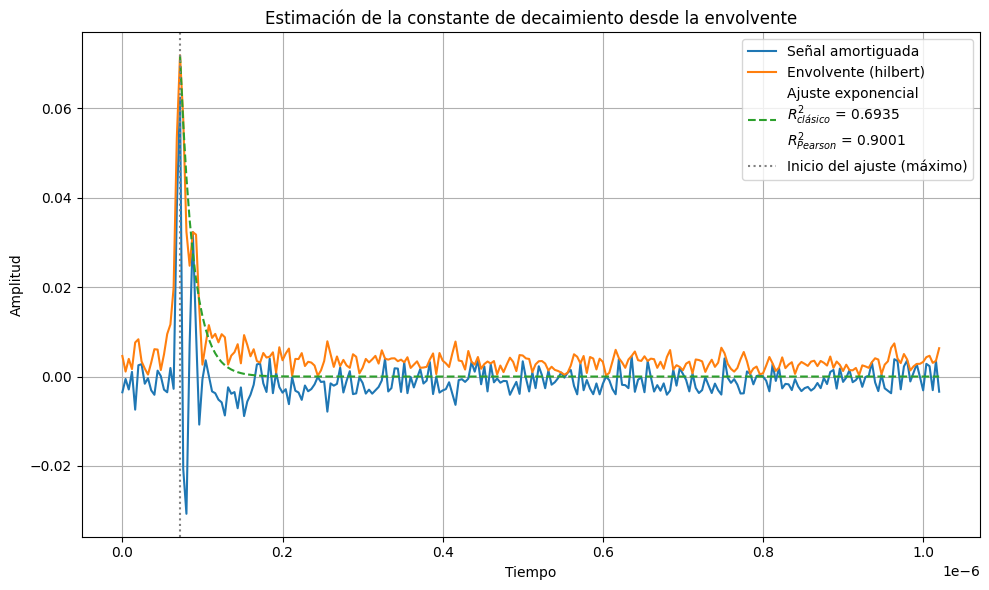

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import hilbert
from scipy.stats import pearsonr
# 1. Obtener la envolvente con hilbert
analytic_signal = hilbert(df[10])
envelope = np.abs(analytic_signal)

# 2. Índice del máximo de la envolvente
max_idx = np.argmax(envelope)
if max_idx>250:
    max_idx=250

# 3. Recortar desde el máximo
tiempo_recortado = tiempo[max_idx:]
envelope_recortada = envelope[max_idx:]

# 5. Modelo exponencial con A fijo
def expo_decay_fixed_A(t, alpha):
    A0 = envelope_recortada[0]
    return A0 * np.exp(-alpha * (t - t[0]))

# 6. Ajuste
popt, pcov = curve_fit(expo_decay_fixed_A, tiempo_recortado, envelope_recortada, p0=[0.1])
alpha_fit = popt[0]
A_fit = envelope_recortada[0]
ajuste = expo_decay_fixed_A(tiempo_recortado, alpha_fit)

# 7. Métricas de ajuste
residuos = envelope_recortada - ajuste
ss_res = np.sum(residuos**2)
ss_tot = np.sum((envelope_recortada - np.mean(envelope_recortada))**2)
r2_clasico = 1 - (ss_res / ss_tot)
r2_clasico = max(0, r2_clasico)  # truncado entre 0 y 1

r, _ = pearsonr(envelope_recortada, ajuste)
r2_pearson = r**2

# 8. Imprimir resultados
print(f"Constante de decaimiento estimada: alpha = {1e6 / alpha_fit:.4f} µs")
print(f"R² clásico (truncado): {r2_clasico:.4f}")
print(f"R² Pearson: {r2_pearson:.4f}")

# 9. Graficar
plt.figure(figsize=(10,6))
plt.plot(tiempo, df[10], label='Señal amortiguada')
plt.plot(tiempo, envelope, label='Envolvente (hilbert)')
plt.plot(tiempo_recortado, ajuste, '--', label=f'Ajuste exponencial\n$R^2_{{clásico}}$ = {r2_clasico:.4f}\n$R^2_{{Pearson}}$ = {r2_pearson:.4f}')
plt.axvline(tiempo[max_idx], color='gray', linestyle=':', label='Inicio del ajuste (máximo)')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Estimación de la constante de decaimiento desde la envolvente')
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import hilbert

# Iterar sobre todas las señales de dfr (cada fila)
constantes_tiempo = []
for i in range(dfr.shape[0]):
    print(i)
    signal = dfr[i]
    tau = calcular_constante_tiempo(signal, tiempo)
    constantes_tiempo.append(tau)

constantes_tiempo = np.array(constantes_tiempo)

print("Constantes de tiempo calculadas para cada señal:")
print(constantes_tiempo)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

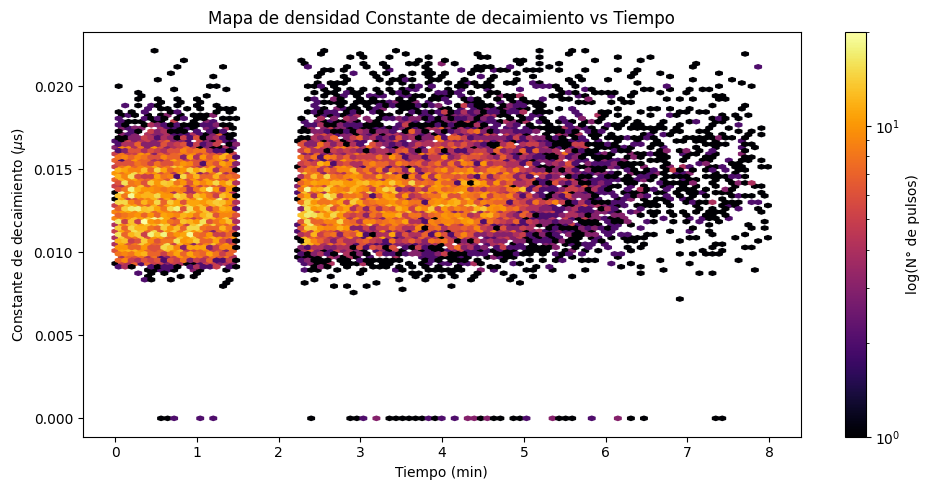

In [25]:
plt.figure(figsize=(10, 5))
mean = np.nanmean(constantes_tiempo)   # media ignorando NaN
std = np.nanstd(constantes_tiempo)     # desviación estándar

# Definir máscara para valores outlier
outliers = (constantes_tiempo > mean + 3.5*std) | (constantes_tiempo < 0)

# Reemplazar outliers por 0
constantes_tiempo[outliers] = 0
plt.hexbin(tiempo_arbol[0][0:num_ts]/60, constantes_tiempo[0:num_ts], gridsize=100, cmap='inferno', bins='log')
plt.xlabel('Tiempo (min)')
plt.ylabel(r'Constante de decaimiento ($\mu$s)')
plt.title('Mapa de densidad Constante de decaimiento vs Tiempo')
cb = plt.colorbar(label='log(N° de pulsos)')
plt.tight_layout()
plt.show()

c:\Users\nicol\miniconda3\envs\gpuenv\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 7 is too high: all coefficients will experience boundary effects.
  warnings.warn(


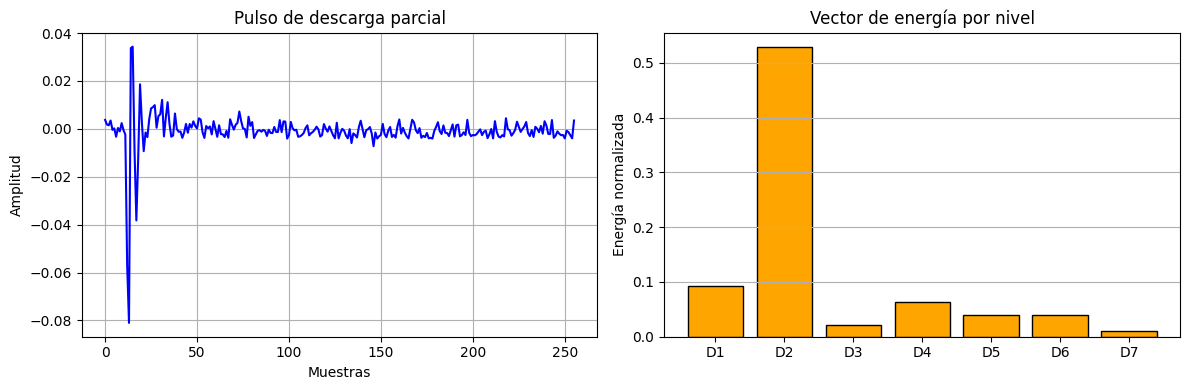

In [26]:
# Supón que ya tienes la señal
senal = dfr[23]
ev = energia_wavelet_por_nivel(senal, wavelet='sym9', niveles=7)

# Invertir niveles y energías (de D7 a D1)
niveles = [f'D{i+1}' for i in range(7)]  # ['D7', 'D6', ..., 'D1']
ev_detalles = ev[:-1][::-1]  # Excluye A7 y revierte el orden

# Gráfico
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# 1. Señal temporal
axs[0].plot(senal, color='blue')
axs[0].set_title('Pulso de descarga parcial')
axs[0].set_xlabel('Muestras')
axs[0].set_ylabel('Amplitud')
axs[0].grid(True)

# 2. Vector de energía por nivel (Detalles D7-D1)
axs[1].bar(niveles, ev_detalles, color='orange', edgecolor='black')
axs[1].set_title('Vector de energía por nivel')
axs[1].set_ylabel('Energía normalizada')
axs[1].grid(axis='y')

plt.tight_layout()
plt.show()


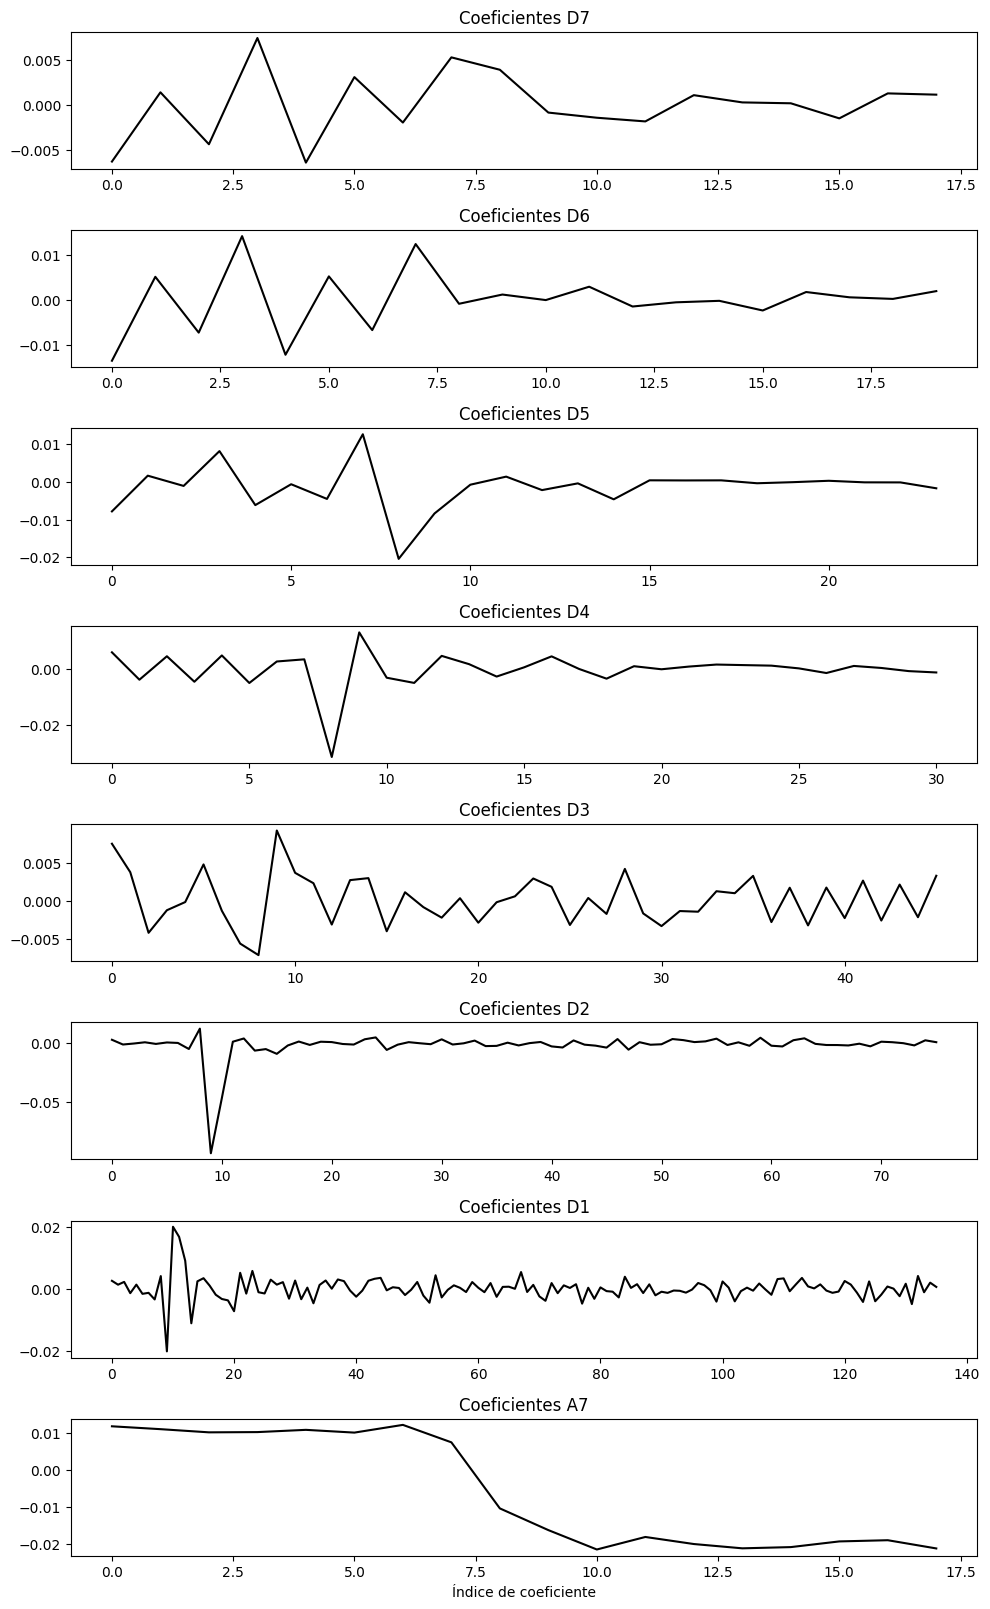

In [27]:
graficar_niveles_wavelet(senal, wavelet='sym9', niveles=7)

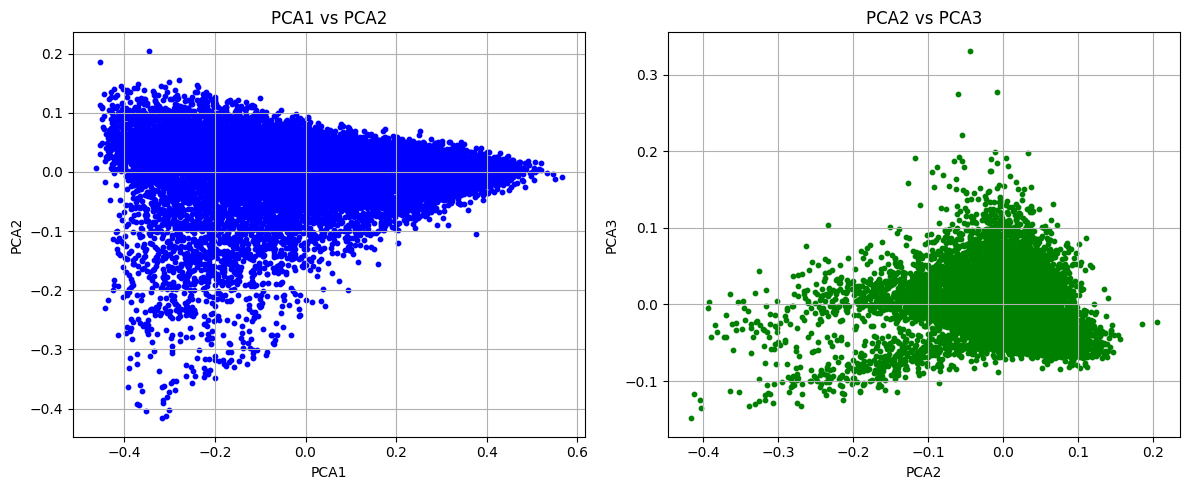

In [28]:
num_pulsos = dfr.shape[0]
matriz_energia = []

for i in range(num_pulsos):
    senal = dfr[i, :]
    if senal.ndim == 1:
        ev = energia_wavelet_por_nivel(senal)
        ev_detalles = ev[::-1]
        matriz_energia.append(ev_detalles)

matriz_energia = np.array(matriz_energia)  # M x 8

# --- Aplicar PCA ---
pca = PCA(n_components=3)
pca_resultado = pca.fit_transform(matriz_energia)  # M x 3

# --- Visualización ---
fig = plt.figure(figsize=(12, 5))

# PCA1 vs PCA2
plt.subplot(1, 2, 1)
plt.scatter(pca_resultado[:, 0], pca_resultado[:, 1], c='blue', s=10)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA1 vs PCA2')
plt.grid(True)

# PCA2 vs PCA3
plt.subplot(1, 2, 2)
plt.scatter(pca_resultado[:, 1], pca_resultado[:, 2], c='green', s=10)
plt.xlabel('PCA2')
plt.ylabel('PCA3')
plt.title('PCA2 vs PCA3')
plt.grid(True)

plt.tight_layout()
plt.show()

In [29]:
print("Máximo valor en matriz_energia:", np.max(matriz_energia))
print("Mínimo valor:", np.min(matriz_energia))
print("Media por columna:", np.mean(matriz_energia, axis=0))
print("Desviación estándar por columna:", np.std(matriz_energia, axis=0))
print("Suma total por fila (debe ser ~1):", np.sum(matriz_energia, axis=1)[:5])

Máximo valor en matriz_energia: 0.8954382
Mínimo valor: 0.0013791968
Media por columna: [0.39817196 0.22841018 0.17830567 0.07419343 0.03987651 0.04530258
 0.01564856 0.02009176]
Desviación estándar por columna: [0.18745595 0.0897279  0.07598508 0.03184774 0.01752062 0.01613086
 0.00785257 0.00714889]
Suma total por fila (debe ser ~1): [0.9999999 1.        0.9999999 1.        1.       ]


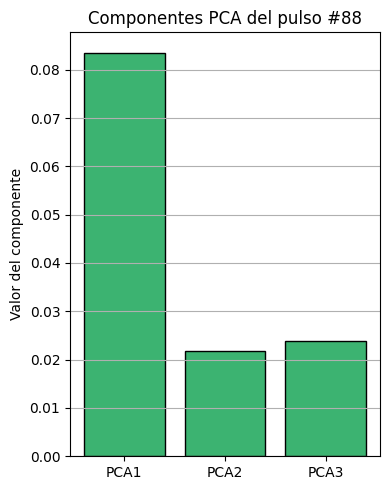

In [30]:
indice_pulso = 88
valores_pca = pca_resultado[indice_pulso, :]  # [PCA1, PCA2, PCA3]

# Etiquetas de los componentes
componentes = ['PCA1', 'PCA2', 'PCA3']

# Gráfico de barras
plt.figure(figsize=(4, 5))
plt.bar(componentes, np.abs(valores_pca), color='mediumseagreen', edgecolor='black')
plt.title(f'Componentes PCA del pulso #{indice_pulso}')
plt.ylabel('Valor del componente')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [31]:
pca_resultado.shape[0]

17367

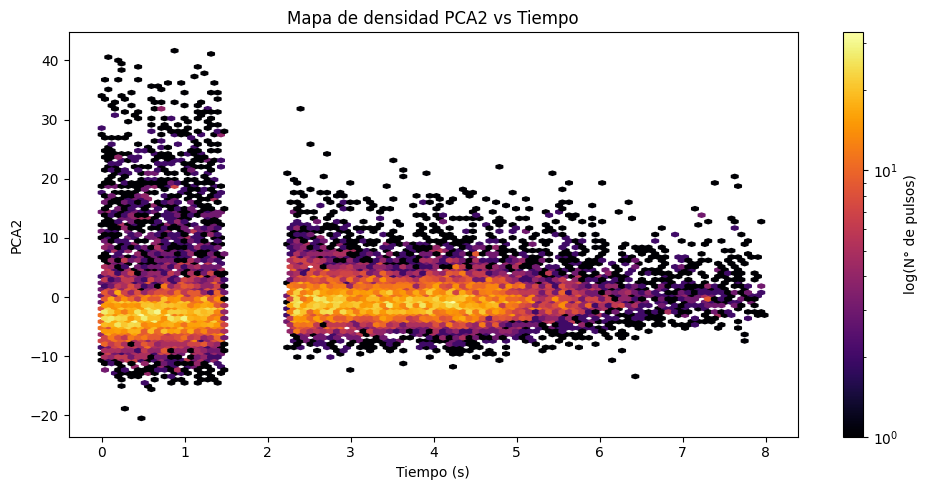

In [32]:
# Asegúrate de que tiempo_arbol tenga la misma longitud que el número de pulsos
assert len(tiempo_arbol[0][0:num_ts]) == pca_resultado.shape[0], "¡Longitudes no coinciden!"

# Extraer PCA2
pca1=-pca_resultado[:, 0]
pca2 = -pca_resultado[:, 1]
pca3= -pca_resultado[:, 2]

plt.figure(figsize=(10, 5))

plt.hexbin(tiempo_arbol[0][0:num_ts]/60, pca2*100, gridsize=100, cmap='inferno', bins='log')
plt.xlabel('Tiempo (s)')
plt.ylabel('PCA2')
plt.title('Mapa de densidad PCA2 vs Tiempo')
cb = plt.colorbar(label='log(N° de pulsos)')
plt.tight_layout()
plt.show()


### Generacion de espectrogramas

5.6841914e-12
1.2972383e-18
Shape del tensor procesado: (17367, 28, 28, 1)


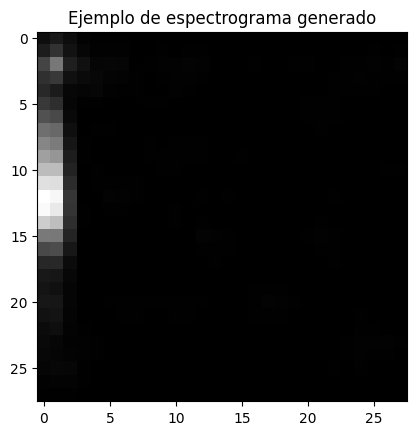

In [33]:
n_samples = num_ts
waveform_length = dfr.shape[1]
processed_images = preprocess_waveforms(dfr, sample_rate, target_size=(espec_size, espec_size), channels=1)
print("Shape del tensor procesado:", processed_images.shape)
plt.imshow(processed_images[0].reshape(espec_size, espec_size), cmap='gray')
plt.title("Ejemplo de espectrograma generado")
plt.show()
#print(processed_images)

In [34]:
BUFFER_SIZE = processed_images.shape[0]
BATCH_SIZE = 256
train_images = processed_images.reshape(processed_images.shape[0], espec_size, espec_size, 1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(processed_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Modelado de la GAN


Tanto el generador como el discriminador se definen utilizando la API secuencial de Keras.(https://www.tensorflow.org/guide/keras#sequential_model).

### El generador
El generador utiliza capas de tf.keras.layers.Conv2DTranspose (remuestreo ascendente) para producir una imagen a partir de una semilla (ruido aleatorio). Comienza con una capa Densa que toma esta semilla como entrada y luego realiza varios remuestreos ascendentes hasta alcanzar el tamaño de imagen deseado de 28x28x1. Observa que se utiliza la activación tf.keras.layers.LeakyReLU en cada capa, excepto en la capa de salida, que utiliza tanh.

In [35]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(int(espec_size/4)*int(espec_size/4)*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((int(espec_size/4), int(espec_size/4), 256)))
    assert model.output_shape == (None, int(espec_size/4), int(espec_size/4), 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, int(espec_size/4), int(espec_size/4), 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, int(espec_size/2), int(espec_size/2), 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, espec_size, espec_size, 1)

    return model

Usando el generador no entrenado para generar una imagen inicial

c:\Users\nicol\miniconda3\envs\gpuenv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


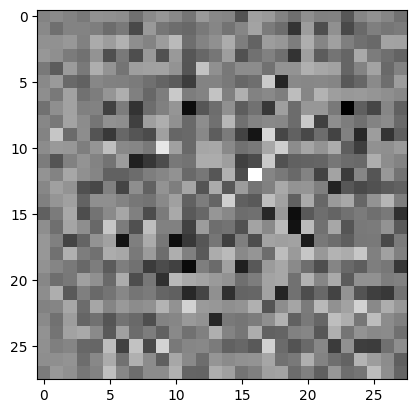

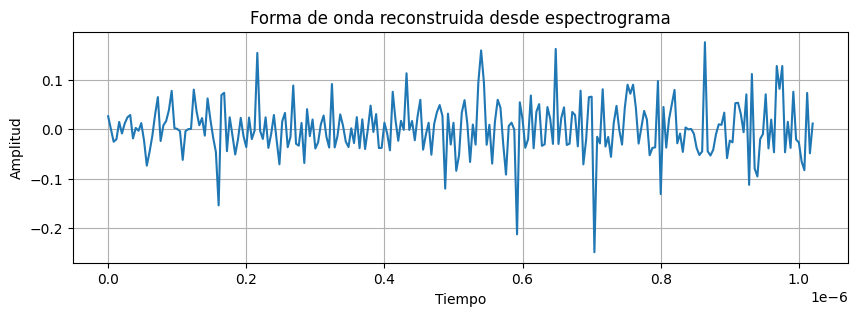

Constante de decaimiento estimada: alpha = 0.0904 µs
R² clásico (truncado): 0.0000
R² Pearson: 0.0047


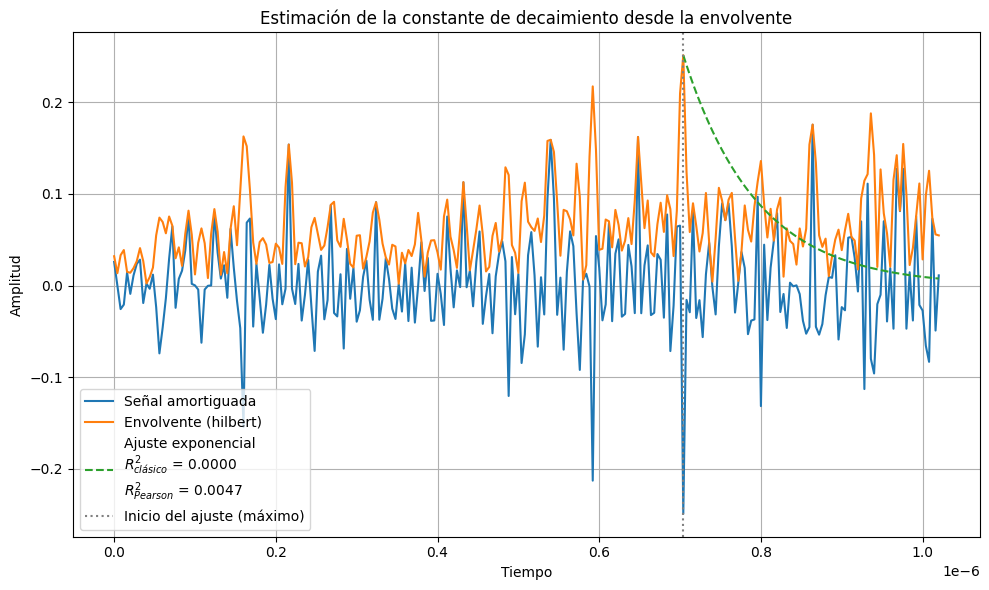

In [36]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
#print(generated_image)

fo_o=inverse_spectrogram(generated_image[0, :, :, 0], frecuencia_muestreo, 256)
plt.figure(figsize=(10, 3))
plt.plot(tiempo,fo_o)
plt.title("Forma de onda reconstruida desde espectrograma")
plt.xlabel("Tiempo")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()


import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import hilbert
from scipy.stats import pearsonr

# 1. Envolvente de Hilbert
analytic_signal = hilbert(fo_o)
envelope = np.abs(analytic_signal)

# 2. Índice del máximo de la envolvente
max_idx = np.argmax(envelope)

# 3. Recortar desde el máximo
tiempo_recortado = tiempo[max_idx:]
envelope_recortada = envelope[max_idx:]

# 5. Modelo exponencial con A fijo
def expo_decay_fixed_A(t, alpha):
    A0 = envelope_recortada[0]
    return A0 * np.exp(-alpha * (t - t[0]))

# 6. Ajuste
popt, pcov = curve_fit(expo_decay_fixed_A, tiempo_recortado, envelope_recortada, p0=[0.1])
alpha_fit = popt[0]
A_fit = envelope_recortada[0]
ajuste = expo_decay_fixed_A(tiempo_recortado, alpha_fit)

# 7. Métricas de ajuste
residuos = envelope_recortada - ajuste
ss_res = np.sum(residuos**2)
ss_tot = np.sum((envelope_recortada - np.mean(envelope_recortada))**2)
r2_clasico = 1 - (ss_res / ss_tot)
r2_clasico = max(0, r2_clasico)  # truncado entre 0 y 1

r, _ = pearsonr(envelope_recortada, ajuste)
r2_pearson = r**2

# 8. Imprimir resultados
print(f"Constante de decaimiento estimada: alpha = {1e6 / alpha_fit:.4f} µs")
print(f"R² clásico (truncado): {r2_clasico:.4f}")
print(f"R² Pearson: {r2_pearson:.4f}")

# 9. Graficar
plt.figure(figsize=(10,6))
plt.plot(tiempo, fo_o, label='Señal amortiguada')
plt.plot(tiempo, envelope, label='Envolvente (hilbert)')
plt.plot(tiempo_recortado, ajuste, '--', label=f'Ajuste exponencial\n$R^2_{{clásico}}$ = {r2_clasico:.4f}\n$R^2_{{Pearson}}$ = {r2_pearson:.4f}')
plt.axvline(tiempo[max_idx], color='gray', linestyle=':', label='Inicio del ajuste (máximo)')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Estimación de la constante de decaimiento desde la envolvente')
plt.grid(True)
plt.tight_layout()
plt.show()


### El Discriminador
El discriminador es un clasificador de imágenes basado en una red neuronal convolucional (CNN).

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
def make_discriminator_model():
    model = Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',input_shape=[espec_size, espec_size, 1]))
    model.add(layers.Dropout(0.3))
    model.add(MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(layers.Dropout(0.3))
    model.add(MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model




Utiliza el discriminador (aún no entrenado) para clasificar las imágenes generadas como reales o falsas. El modelo se entrenará para producir valores positivos para las imágenes reales y valores negativos para las imágenes falsas.

In [38]:

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.01507354]], shape=(1, 1), dtype=float32)


c:\Users\nicol\miniconda3\envs\gpuenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Define the loss and optimizers
Define funciones de pérdida y optimizadores para ambos modelos.

In [39]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Función de perdida del discriminador

Este método cuantifica qué tan bien el discriminador es capaz de distinguir las imágenes reales de las falsas. Compara las predicciones del discriminador sobre las imágenes reales con un arreglo de 1s, y sus predicciones sobre las imágenes falsas (generadas) con un arreglo de 0s.

In [40]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Función de perdida del generador
La pérdida del generador cuantifica qué tan bien logró engañar al discriminador. Intuitivamente, si el generador está funcionando bien, el discriminador clasificará las imágenes falsas como reales (o 1). Aquí, se comparan las decisiones del discriminador sobre las imágenes generadas con un arreglo de 1s.

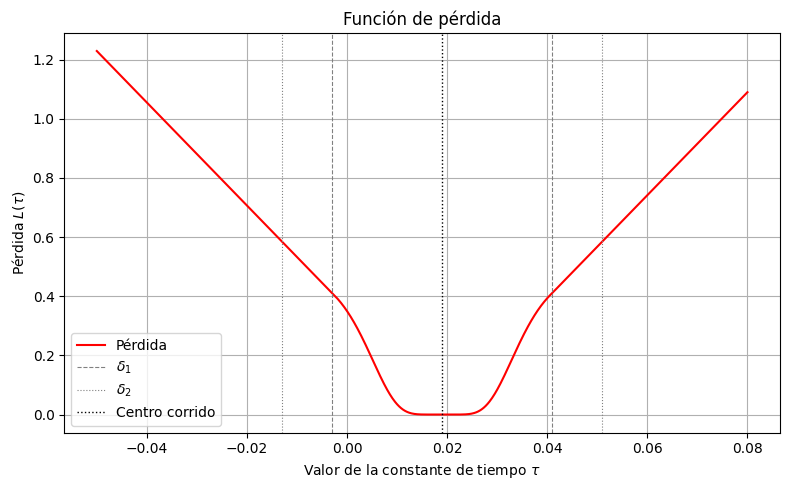

In [55]:
import numpy as np
import matplotlib.pyplot as plt

def smooth_huber_tanh(error, delta1, delta2, alpha=100.0):
    error = np.asarray(error)
    abs_err = np.abs(error)
    loss = np.zeros_like(error)

    # Zona tanh^2
    mask_tanh = abs_err <= delta1
    loss[mask_tanh] = 0.5 * np.tanh(alpha * error[mask_tanh])**8

    # Valores y derivadas para la spline cúbica
    tanh1 = np.tanh(alpha * delta1)
    val1 = 0.5 * tanh1**8
    dval1 = alpha * tanh1 * (1 - tanh1**8)

    m = dval1
    val2 = val1 + m * (delta2 - delta1)
    dval2 = m

    x0, x1 = 0, delta2 - delta1
    A = np.array([
        [x0**3, x0**2, x0, 1],
        [x1**3, x1**2, x1, 1],
        [3*x0**2, 2*x0, 1, 0],
        [3*x1**2, 2*x1, 1, 0],
    ])
    Y = np.array([val1, val2, dval1, dval2])
    a, b, c, d = np.linalg.solve(A, Y)

    # Zona spline
    mask_spline = (abs_err > delta1) & (abs_err <= delta2)
    dx_spline = abs_err[mask_spline] - delta1
    loss[mask_spline] = a * dx_spline**3 + b * dx_spline**2 + c * dx_spline + d

    # Zona lineal
    mask_outer = abs_err > delta2
    dx_outer = abs_err[mask_outer] - delta2
    loss[mask_outer] = val2 + m * dx_outer

    return loss

# Parámetros
minimo = 0.008
maximo = 0.03
delta1 = (maximo - minimo)
delta2 = delta1 + 0.01
corrimiento = (maximo + minimo)/2

# Rango de error
xr = np.linspace(-0.05, 0.08, 1000)
error_shifted = xr - corrimiento
loss_vals = smooth_huber_tanh(error_shifted, delta1, delta2, alpha=100)

# Graficar
plt.figure(figsize=(8, 5))
plt.plot(xr, loss_vals, color='red', label="Pérdida")

# Líneas verticales
plt.axvline(x=corrimiento - delta1, color='gray', linestyle='--', linewidth=0.8, label=r'$\delta_1$')
plt.axvline(x=corrimiento + delta1, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(x=corrimiento - delta2, color='gray', linestyle=':', linewidth=0.8, label=r'$\delta_2$')
plt.axvline(x=corrimiento + delta2, color='gray', linestyle=':', linewidth=0.8)
plt.axvline(x=corrimiento, color='black', linestyle=':', linewidth=1, label='Centro corrido')

# Estética
plt.title("Función de pérdida")
plt.xlabel("Valor de la constante de tiempo $\\tau$")
plt.ylabel("Pérdida $L(\\tau)$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()







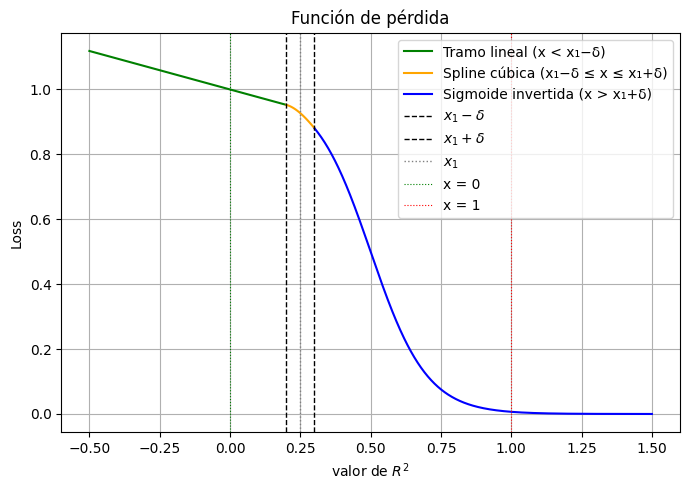

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def inverted_sigmoid(x, x1=0.25, k=10, delta=0.05):
    y = np.zeros_like(x)

    def sig_inv(z): return 1 / (1 + np.exp(k * (z - 0.5)))

    x_left = x1 - delta
    x_right = x1 + delta

    yL = 1 + ((sig_inv(x_left) - 1) / (x_left)) * (x_left)
    dyL = (sig_inv(x_left) - 1) / (x_left)

    yR = sig_inv(x_right)
    dyR = -k * yR * (1 - yR)

    A = np.array([
        [x_left**3, x_left**2, x_left, 1],
        [x_right**3, x_right**2, x_right, 1],
        [3*x_left**2, 2*x_left, 1, 0],
        [3*x_right**2, 2*x_right, 1, 0],
    ])
    b = np.array([yL, yR, dyL, dyR])
    a3, a2, a1, a0 = np.linalg.solve(A, b)

    def spline(z): return a3*z**3 + a2*z**2 + a1*z + a0

    mask_left = x < x_left
    mask_spline = (x >= x_left) & (x <= x_right)
    mask_right = x > x_right

    y[mask_left] = 1 + dyL * (x[mask_left])
    y[mask_spline] = spline(x[mask_spline])
    y[mask_right] = sig_inv(x[mask_right])

    return y, mask_left, mask_spline, mask_right, x_left, x_right

# Rango
x = np.linspace(-0.5, 1.5, 1000)
y, mask_left, mask_spline, mask_right, x_left, x_right = inverted_sigmoid(x)

# Gráfico
plt.figure(figsize=(7, 5))

plt.plot(x[mask_left], y[mask_left], color='green', label='Tramo lineal (x < x₁−δ)')
plt.plot(x[mask_spline], y[mask_spline], color='orange', label='Spline cúbica (x₁−δ ≤ x ≤ x₁+δ)')
plt.plot(x[mask_right], y[mask_right], color='blue', label='Sigmoide invertida (x > x₁+δ)')

# Marcar puntos de transición
plt.axvline(x_left, linestyle='--', color='black', linewidth=1, label=r'$x_1 - \delta$')
plt.axvline(x_right, linestyle='--', color='black', linewidth=1, label=r'$x_1 + \delta$')
plt.axvline(0.25, linestyle=':', color='gray', linewidth=1, label=r'$x_1$')

plt.axvline(0, color='green', linestyle=':', linewidth=0.8, label='x = 0')
plt.axvline(1, color='red', linestyle=':', linewidth=0.8, label='x = 1')

plt.xlabel('valor de $R^2$')
plt.ylabel('Loss')
plt.title('Función de pérdida')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()






In [43]:
def generator_loss(fake_output,generated_images):
    fo_o=inverse_spectrogram(generated_images[0, :, :, 0], frecuencia_muestreo, 256)
    analytic_signal = hilbert(fo_o)
    envelope = np.abs(analytic_signal)

    # 2. Encontrar el índice del máximo valor de la envolvente
    max_idx = np.argmax(envelope)

    # 3. Recortar tiempo y envolvente desde ese máximo
    tiempo_recortado = tiempo[max_idx:]
    envelope_recortada = envelope[max_idx:]

    # 4. Definir función exponencial con A fijo para que pase por el máximo
    def expo_decay_fixed_A(t, alpha_f):
        A0 = envelope_recortada[0]  # valor de la envolvente en el máximo
        return A0 * np.exp(-alpha_f * (t - t[0]))

    # 5. Ajustar solo alpha
    popt, pcov = curve_fit(expo_decay_fixed_A, tiempo_recortado, envelope_recortada, p0=[0.1])
    
    alpha_fit = popt[0]
    A_fit = envelope_recortada[0]
    ajuste = expo_decay_fixed_A(tiempo_recortado, alpha_fit)
    cte_tiempo=1*(10**6)/alpha_fit
    residuos = envelope_recortada - ajuste
    ss_res = np.sum(residuos**2)
    ss_tot = np.sum((envelope_recortada - np.mean(envelope_recortada))**2)
    r2_clasico = 1 - (ss_res / ss_tot)
    r2_clasico = max(0, r2_clasico)  # truncado entre 0 y 1

    r, _ = pearsonr(envelope_recortada, ajuste)
    r2_pearson = r**2
    minimo = 0.008
    maximo = 0.03
    delta1 = (maximo - minimo)      # transición desde tanh^2
    delta2 = delta1 + 0.01          # pequeño rango spline
    corrimiento = (maximo + minimo)/2

    
    print('constante de tiempo: ',cte_tiempo)
    print('pérdida por constante de tiempo: ', smooth_huber_tanh(cte_tiempo - corrimiento, delta1, delta2, alpha=100))
    print('r2 clasico: ', r2_clasico)
    print('pérdida por r2 clasico: ',inverted_sigmoid(r2_clasico, k=10))

    
    return 0.3*cross_entropy(tf.ones_like(fake_output), fake_output) + 0.1*(1-inverted_sigmoid(r2_clasico,0.25, k=10))*(smooth_huber_tanh(cte_tiempo - corrimiento, delta1, delta2, alpha=100)) + 0.3*inverted_sigmoid(r2_clasico,0.25, k=10)


Los optimizadores del discriminador y del generador son diferentes, ya que se entrenarán dos redes por separado.

In [44]:

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [45]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Ajuste de los parámetros de entrenamiento


In [46]:

num_examples_to_generate = int(num_ts*0.1)

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


El ciclo de entrenamiento comienza con el generador recibiendo una semilla aleatoria como entrada. Esa semilla se utiliza para producir una imagen. Luego, el discriminador se usa para clasificar imágenes reales (extraídas del conjunto de entrenamiento) e imágenes falsas (producidas por el generador). Se calcula la pérdida para cada uno de estos modelos, y los gradientes se utilizan para actualizar el generador y el discriminador.

In [47]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
#@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output,generated_images)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return (gen_loss,disc_loss)




In [48]:


def generate_and_save_images_and_waveforms(generator, epoch, test_input, fs, original_length=256, num_waveforms=16):
    predictions = generator(test_input, training=False)
    #print(predictions)
    reconstructed_waveforms = []
    for i in range(predictions.shape[0]):
        reconstructed_waveform = inverse_spectrogram(predictions[i, :, :, 0], fs, original_length)
        reconstructed_waveforms.append(reconstructed_waveform)

    fig, axs = plt.subplots(4, 8, figsize=(12, 24))
    for i in range(num_waveforms):
        row = i // 4
        col = i % 4
        axs[row, col].imshow(predictions[i, :, :, 0], cmap='gray')
        axs[row, col].axis('off')
        axs[row, col].set_title(f'Espectrograma {i+1}')
        axs[row, col+4].plot(np.linspace(0, 1, original_length), reconstructed_waveforms[i], color='gray')
        axs[row, col+4].axis('off')
        axs[row, col+4].set_title(f'Onda {i+1}')
    plt.tight_layout()

    plt.savefig(f'combined_images_waveforms_at_epoch_{epoch:04d}.png')
    plt.show()
    return reconstructed_waveforms


In [49]:
def train(dataset, epochs):
    ep=[]
    lsg=[]
    lsd=[]
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            ep.append(epoch)
            gl,dl=train_step(image_batch)
            lsg.append(gl)
            lsd.append(dl)

        display.clear_output(wait=True)
        generate_and_save_images_and_waveforms(generator,
                                               epoch + 1,
                                               seed, sample_rate)

        # Save the model every 15 epochs
        if (epoch + 1) ==1:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


    display.clear_output(wait=True)
    generate_and_save_images_and_waveforms(generator,
                                           epoch + 1,
                                           seed, sample_rate)
    plt.figure()
    plt.figure()
    plt.title('loss')
    plt.plot(ep, lsg,color='red',marker='.', label='generator loss')
    plt.plot(ep, lsd,color='blue',marker='.',label='discriminator loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('Amplitud')
    plt.show()

    return generate_and_save_images_and_waveforms(generator,epoch + 1,seed, sample_rate)

## Entrenamiento del modelo
Llama al método train() definido anteriormente para entrenar simultáneamente el generador y el discriminador. Ten en cuenta que entrenar GANs puede ser complicado. Es importante que el generador y el discriminador no se superen entre sí (por ejemplo, que entrenen a una velocidad similar).

In [50]:

print(tf.config.list_physical_devices('GPU'))

[]


In [51]:
EPOCHS=10
ondas=train(train_dataset, EPOCHS)
ondas_generadas=np.array(ondas)

constante de tiempo:  0.1469615750046035
pérdida por constante de tiempo:  (array(2.25486136), np.False_, np.False_, np.True_)
r2 clasico:  0
pérdida por r2 clasico:  1


TypeError: can't multiply sequence by non-int of type 'numpy.float64'

## Etapa de comparación con los datos reales

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Analisis de Descargas parciales generadas

(1736,)


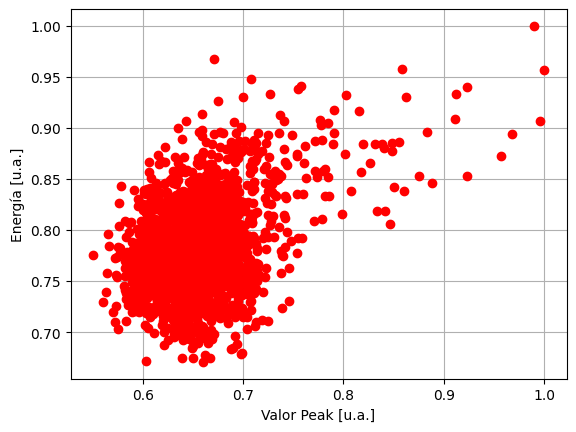

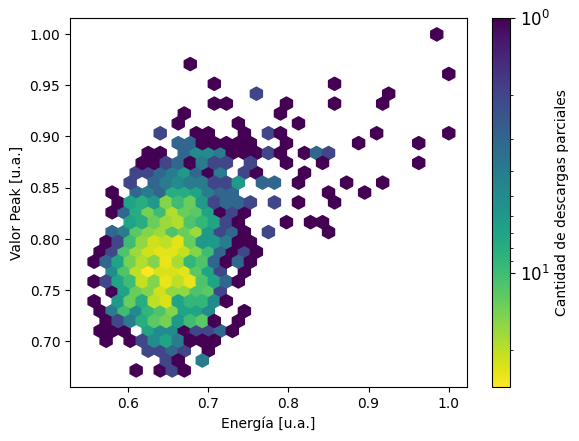

In [ ]:
vp_gen,e_gen=grafico_VP_EN(ondas_generadas,frecuencia_muestreo,A_pass_limit,frec_limit,dat,lim_sup)

### Analisis de Descargas parciales reales

(17367,)


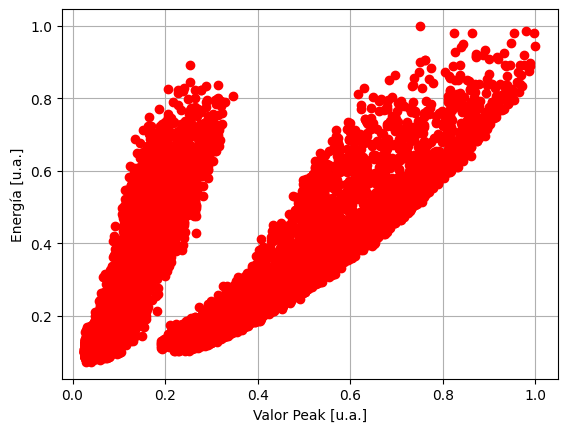

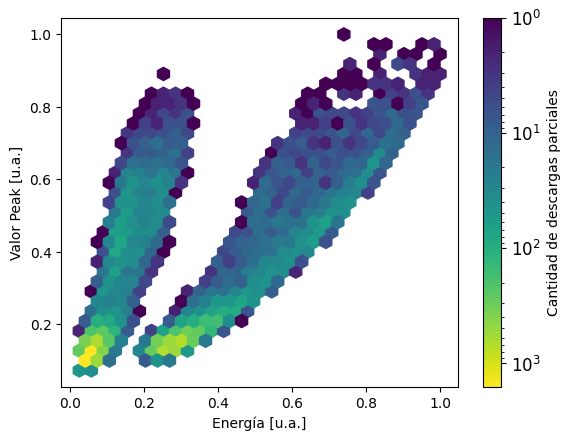

In [ ]:
vp_real,e_real=grafico_VP_EN(dfr,frecuencia_muestreo,A_pass_limit,frec_limit,dat,lim_sup)

Un resultado interesante que se puede apreciar, es que al separar las descargas parciales por su valor peak y energia, se generan dos grupos, por lo que esto acusa que existen dos clases de descargas parciales en la etapa de iniciacion, es por esta razon que se realizara el mismo proceso de generan de descargas parciales por medio de la GAN ahora con los conjuntos de datos separados.

### Generacion de etiquetas de DPs en iniciación
Como se pudo apreciar al comparar el valor peak de las señales con su energia, existen dos tipos de descargas parciales, es por esto que ahora se generaran dos conjuntos de datos por medio de un clasificador no supervisado, de modo que separe los tipos de descargas parciales en dos conjuntos de datos distintos

(17367,)


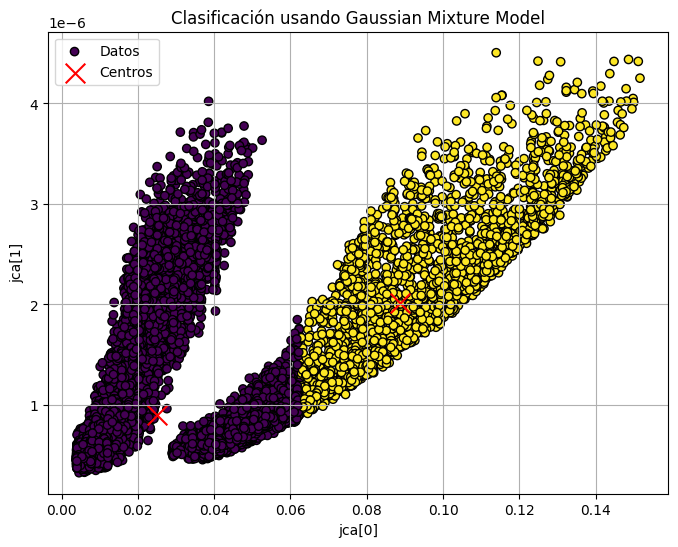

ModuleNotFoundError: No module named 'openpyxl'

In [ ]:
carac_reales=caracterizacion(dfr,frecuencia_muestreo,A_pass_limit,frec_limit,dat,lim_sup)
ruta_salida = r'C:\Users\nicol\OneDrive\Desktop\DII\Paper GAN PD'  # Cambia a tu ruta deseada
etiqueta_filtro1 = 'tipo1'  # Especifica la etiqueta a filtrar
etiqueta_filtro2 = 'tipo2'  # Especifica la etiqueta a filtrar
df_completo, descarga_tipo_1 = unsupervised_clustering(carac_reales, dfr, ruta_salida, etiqueta_filtro1)
df_completo2, descarga_tipo_2 = unsupervised_clustering(carac_reales, dfr, ruta_salida, etiqueta_filtro2)

In [ ]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU devices:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
Num GPUs Available: 0
GPU devices: []


##Análisis de descargas tipo 1

In [ ]:
formas_onda_sin_etiqueta_tipo_1 = descarga_tipo_1.drop(columns=['Etiqueta'])
formas_onda_sin_etiqueta_tipo_1 = formas_onda_sin_etiqueta_tipo_1.values
dfparticionado_tipo_1=formas_onda_sin_etiqueta_tipo_1
descarga_parcial_tipo_1=dfparticionado_tipo_1[0,:]
descargas_tipo_1=dfparticionado_tipo_1[:,1]
for i in range(descargas_tipo_1.shape[0]):
    descarga_parcial_tipo_1=descarga_parcial_tipo_1+dfparticionado_tipo_1[i,:]
descarga_parcial_tipo_1=descarga_parcial_tipo_1/descargas_tipo_1.shape[0]
num_ts_tipo_1=len(dfparticionado_tipo_1[:,1])
descarga_tipo_1_part = dfparticionado_tipo_1[0:num_ts_tipo_1,:]
vp_real_tipo_1,e_real_tipo_1=grafico_VP_EN(descarga_tipo_1_part,frecuencia_muestreo,A_pass_limit,frec_limit,dat,lim_sup)
processed_images_tipo_1 = preprocess_waveforms(descarga_tipo_1_part, sample_rate, target_size=(espec_size, espec_size), channels=1)
print("Shape del tensor procesado:", processed_images_tipo_1.shape)
plt.imshow(processed_images_tipo_1[0].reshape(espec_size, espec_size), cmap='gray')
plt.title("Ejemplo de espectrograma generado")
plt.show()
#print(processed_images)

### Generacion de descargas parciales de tipo 1 en iniciación

In [ ]:
BUFFER_SIZE = processed_images_tipo_1.shape[0]  # Tamaño del dataset
BATCH_SIZE = 256
train_images_tipo_1 = processed_images_tipo_1.reshape(processed_images_tipo_1.shape[0], espec_size, espec_size, 1).astype('float32')
#train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

train_dataset_tipo_1 = tf.data.Dataset.from_tensor_slices(processed_images_tipo_1).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
ondas_tipo_1=train(train_dataset_tipo_1, EPOCHS)
ondas_tipo_1=np.array(ondas_tipo_1)

## Distribución de valor peak versus energía

In [ ]:
vp_tipo_1_gen,e_tipo_1_gen=grafico_VP_EN(ondas_tipo_1,frecuencia_muestreo,A_pass_limit,frec_limit,dat,lim_sup)

##Análisis de descargas tipo 2

In [ ]:
formas_onda_sin_etiqueta_tipo_2 = descarga_tipo_2.drop(columns=['Etiqueta'])
formas_onda_sin_etiqueta_tipo_2 = formas_onda_sin_etiqueta_tipo_2.values
dfparticionado_tipo_2=formas_onda_sin_etiqueta_tipo_2
descarga_parcial_tipo_2=dfparticionado_tipo_2[0,:]
descargas_tipo_2=dfparticionado_tipo_2[:,1]
for i in range(descargas_tipo_2.shape[0]):
    descarga_parcial_tipo_2=descarga_parcial_tipo_2+dfparticionado_tipo_2[i,:]
descarga_parcial_tipo_2=descarga_parcial_tipo_2/descargas_tipo_2.shape[0]
num_ts_tipo_2=len(dfparticionado_tipo_2[:,1])
descarga_tipo_2_part = dfparticionado_tipo_2[0:num_ts_tipo_2,:]
vp_real_tipo_2,e_real_tipo_2=grafico_VP_EN(descarga_tipo_2_part,frecuencia_muestreo,A_pass_limit,frec_limit,dat,lim_sup)
processed_images_tipo_2 = preprocess_waveforms(descarga_tipo_2_part, sample_rate, target_size=(espec_size, espec_size), channels=1)
#print("Shape del tensor procesado:", processed_images_tipo_2.shape)
plt.imshow(processed_images_tipo_2[0].reshape(espec_size, espec_size), cmap='gray')
plt.title("Ejemplo de espectrograma generado")
plt.show()
#print(processed_images)

## Generacion de descargas parciales de tipo 2 en iniciación

In [ ]:
BUFFER_SIZE = processed_images_tipo_2.shape[0]  # Tamaño del dataset
BATCH_SIZE = 256
train_images_tipo_2 = processed_images_tipo_2.reshape(processed_images_tipo_2.shape[0], espec_size, espec_size, 1).astype('float32')
#train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

train_dataset_tipo_2 = tf.data.Dataset.from_tensor_slices(processed_images_tipo_2).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
ondas_tipo_2=train(train_dataset_tipo_2, EPOCHS)
ondas_tipo_2=np.array(ondas_tipo_2)

## Distribución de valor peak versus energía

In [ ]:
vp_tipo_2_gen,e_tipo_2_gen=grafico_VP_EN(ondas_tipo_2,frecuencia_muestreo,A_pass_limit,frec_limit,dat,lim_sup)

##Análisis de ambos tipos de descargas

En el caso de las descargas parciales del tipo 1 se puede evidenciar que estas poseen un contenido de energía significativamente mas bajo que en el caso de las del tipo 2. Ademas, se puede observar que la relación valor peak versus energía en el caso de las descargas tipo 1 es mayor que en el caso de tipo 2. Estos dos comportamiento se correlacionan con las descargas medidas en laboratorio, donde se sigue el mismo patrón de comportamiento. Sin embargo, las descargas generadas poseen un rango de valores peak menor que en el caso de las descargas medidas en laboratorio, de modo que en este ultimo, hay descargas con un valor peak inferior a $0.4[p.u]$, esto sugiere que el modelo entrenado no ha podido generar descargas con un valor peak bajo ese rango.